In [1]:
from datasets import load_dataset, Audio, DatasetDict, Dataset, load_from_disk, IterableDatasetDict, interleave_datasets, concatenate_datasets

from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor, WhisperForConditionalGeneration, GenerationConfig, WhisperTokenizer, logging, BitsAndBytesConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
# from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from huggingface_hub import notebook_login, create_repo
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import multiprocess as mp
import gc
import time
import numpy as np
# import noisereduce as nr
from scipy import signal
import librosa
import evaluate
import jiwer
import os
import numba
import json
from numba import jit, cuda

import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchaudio
from torch.nn import ZeroPad2d

from torch.utils.data import Dataset, DataLoader


/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
from model import Processor, SpectroDataset, SpectrogramEncoder, UNetDecoder, STSAutoEncoder
from losses import MCDLoss, PerceptualLoss, ContrastiveLoss, AutoencoderLoss
from trainer import Trainer  # Import Trainer from the external script
from evaluation import Evaluator

In [3]:
sampling_rate = 16000
os.environ['KMP_DUPLICATE_LIB_OK']='True'
logging.set_verbosity_warning()
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.version.cuda)

Using device: cuda
12.4


In [4]:
# notebook_login()

In [ ]:
ds = load_dataset('ngdiana/uaspeech_severity_high')

dataset_infos.json:   0%|          | 0.00/948 [00:00<?, ?B/s]

train-00000-of-00011.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

train-00001-of-00011.parquet:   0%|          | 0.00/302M [00:00<?, ?B/s]

train-00002-of-00011.parquet:   0%|          | 0.00/271M [00:00<?, ?B/s]

train-00003-of-00011.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00004-of-00011.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00005-of-00011.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

train-00006-of-00011.parquet:   0%|          | 0.00/297M [00:00<?, ?B/s]

train-00007-of-00011.parquet:   0%|          | 0.00/162M [00:00<?, ?B/s]

train-00008-of-00011.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

train-00009-of-00011.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

train-00010-of-00011.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22524 [00:00<?, ? examples/s]

In [5]:
datasets = IterableDatasetDict()

datasets["train"] = load_from_disk("CommonVoice_EN_train.hf")
datasets["val"] = load_from_disk("CommonVoice_EN_val.hf")

print(f'Train: {len(datasets["train"])}, Val: {len(datasets["val"])}')

Loading dataset from disk:   0%|          | 0/64 [00:00<?, ?it/s]

Train: 780000, Val: 16393


In [6]:
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.models import EncDecRNNTModel

# asr_model_id = "nvidia/stt_it_conformer_transducer_large"
asr_model_id = "nvidia/stt_en_conformer_transducer_large"

asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(asr_model_id)
asr_model.cfg.joint['fuse_loss_wer'] = False
# asr_model.cfg.loss["max_logit_len"] = 150

asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)

asr_model.to(device)

[NeMo I 2025-04-13 20:17:24 mixins:181] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-04-13 20:17:26 modelPT:180] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2025-04-13 20:17:26 features:305] PADDING: 0
[NeMo I 2025-04-13 20:17:30 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-04-13 20:17:30 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-13 20:17:30 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-13 20:17:30 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-13 20:17:30 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-13 20:17:32 save_restore_connector:275] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_transducer_large/snapshots/a40623d1796368b64a9433bce3bcd75fce379a7b/stt_en_conformer_transducer_large.nemo.


EncDecRNNTBPEModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=10240, out_features=512, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-16): 17 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048,

In [7]:
from model import Processor

processor = Processor(asr_model,device)

In [8]:
from lie import localized_smooth_field_1d, localized_smooth_field_2d, generate_lie_generator_fields, apply_transformation


torch.Size([1, 80, 512])


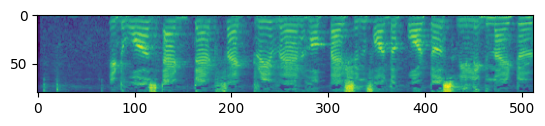

In [9]:
idx = 11
sample = datasets["train"][11]

wf = sample['audio']['array']
S_in = processor.preprocess_nemo_single(wf)
S_in.to(device)
print(S_in.shape)

plt.figure()
plt.imshow(S_in.squeeze().detach().cpu())
plt.show()

torch.Size([80, 512])


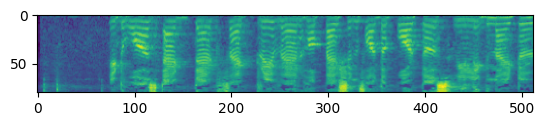

In [10]:
epsilon_dict = {
    't_stretch': 10.0,
    'f_stretch': 10.0,
    'warp_2d': 10.0,
    'amplitude': 100.0,
    'phase': 0.1,
}

fields = generate_lie_generator_fields(80,512,epsilon_dict=epsilon_dict)


S_new =  apply_transformation(S_in.squeeze(0),field=fields['t_stretch'].to(device), mode='t_stretch')
print(S_new.shape)

plt.figure()
plt.imshow(S_new.squeeze().detach().cpu())
plt.show()

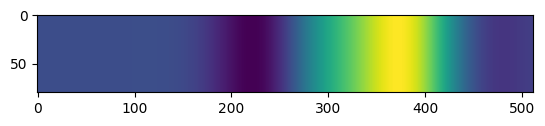

In [11]:
plt.figure()
plt.imshow(fields['t_stretch'].squeeze().detach().cpu())
plt.show()

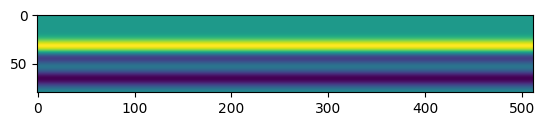

In [12]:
plt.figure()
plt.imshow(fields['f_stretch'].squeeze().detach().cpu())
plt.show()

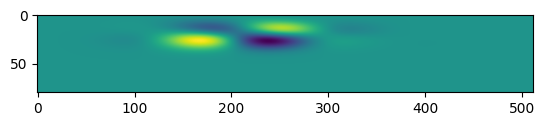

In [13]:
plt.figure()
plt.imshow(fields['warp_2d'][0].squeeze().detach().cpu())
plt.show()

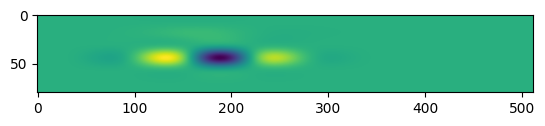

In [14]:
plt.figure()
plt.imshow(fields['amplitude'].squeeze().detach().cpu())
plt.show()

In [15]:
# !pip install segmentation-models-pytorch --quiet
# !pip install timm


In [16]:
import torch.nn.functional as F

def pad_spectrogram(spec, target_height=96):
    """
    Pads a spectrogram [B, 1, F, T] to height=96 (bottom-padding).
    """
    pad_height = target_height - spec.shape[2]
    return F.pad(spec, (0, 0, 0, pad_height))  # pad = (left, right, top, bottom)

def imagenet_normalize_1ch(spec):
    """
    Normalize a 1-channel [B, 1, F, T] spectrogram using ImageNet stats
    (broadcasting mean/std of grayscale version)
    """
    mean = 0.485
    std = 0.229
    return (spec - mean) / std


def normalize_spectrogram(S, min_val=-7.0, max_val=1.0):
    """
    Normalize log-Mel spectrogram from [min_val, max_val] to [0, 1]
    Input: Tensor [F, T]
    Output: Tensor [F, T]
    """
    return (S - min_val) / (max_val - min_val)

def denormalize_spectrogram(S_norm, min_val=-7.0, max_val=1.0):
    return S_norm * (max_val - min_val) + min_val


In [17]:
# field_normalization_ranges = {
#     't_stretch': 0.15,     # Approx max absolute value
#     'f_stretch': 0.15,
#     'warp_2d_v': 0.2,
#     'warp_2d_w': 0.2,
#     'amplitude': 0.3
# }


def normalize_field(field, max_abs):
    """
    Normalize a field from [-max_abs, +max_abs] → [-1, 1]
    """
    return torch.clamp(field / max_abs, min=-1.0, max=1.0)

def denormalize_field(norm_field, max_abs):
    return norm_field * max_abs



def normalize_fields(fields, norm_ranges):
    normed_fields = {}
    for key, value in fields.items():
        if key == 'warp_2d':
            v, w = value
            v_norm = normalize_field(v, norm_ranges['warp_2d'])
            w_norm = normalize_field(w, norm_ranges['warp_2d'])
            normed_fields[key] = (v_norm, w_norm)
        else:
            normed_fields[key] = normalize_field(value, norm_ranges[key])
    return normed_fields

def denormalize_fields(normed_fields, norm_ranges):
    denormed = {}
    for key, value in normed_fields.items():
        if key == 'warp_2d':
            v_norm, w_norm = value
            v = denormalize_field(v_norm, norm_ranges['warp_2d'])
            w = denormalize_field(w_norm, norm_ranges['warp_2d'])
            denormed[key] = (v, w)
        else:
            denormed[key] = denormalize_field(value, norm_ranges[key])
    return denormed


In [18]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class LieFieldPredictor(nn.Module):
    def __init__(self, encoder_name='efficientnet-b0', pretrained=True, in_channels=1, out_channels=5):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=in_channels,
            classes=out_channels,
            activation=None  # No activation here — leave that to post-processing if needed
        )

    def forward(self, x):
        """
        Input: x of shape [B, 1, F, T] (e.g. [B, 1, 80, 512])
        Output: y of shape [B, 5, F, T] — one field per channel
        """
        return self.unet(x)


In [19]:
S_in = S_in.to(device)  # [F, T]
s_min = torch.min(S_in)
s_max = torch.max(S_in)

epsilon_dict = {
't_stretch': 0.5,
'f_stretch': 0.5,
'warp_2d': 0.5,
'amplitude': 0.1,
'phase': 0.0  # unused for now
}  

S_norm = normalize_spectrogram(S_in.squeeze(0),min_val=s_min,max_val=s_max)
print(torch.min(S_norm),torch.max(S_norm))

S_new, fields = apply_lie_transformations(S_norm, 
                                          device=device,
                                          epsilon_dict=epsilon_dict
                                         )



fields_norm = normalize_fields(fields,norm_ranges=epsilon_dict)
print(torch.min(fields_norm['t_stretch']),torch.max(fields_norm['t_stretch']))


In [20]:
# S_norm.shape

In [22]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# class ClampedUnet(nn.Module):
#     def __init__(self, base_model):
#         super().__init__()
#         self.unet = base_model
#         self.clamp = nn.Tanh()  # Enforces [-1, 1]

#     def forward(self, x):
#         return self.clamp(self.unet(x))

backbone = smp.Unet(
    encoder_name="resnext50_32x4d",       # or "efficientnet-b0" or "resnet-34"
    encoder_weights="imagenet",    # pretrained!
    in_channels=1,                 # spectrogram = single channel
    classes=5                      # your scalar fields
)

# model = ClampedUnet(backbone)


model = backbone
model.to(device)


S_input = pad_spectrogram(S_norm.unsqueeze(0).unsqueeze(0))
print(S_input.shape)

pred_fields = model(S_input)
print(pred_fields.shape)

In [ ]:
print(f"MIN: {torch.min(pred_fields)}, MAX: {torch.max(pred_fields)}")

In [ ]:
plt.figure()
plt.imshow(pred_fields[0,0,:,:].detach().cpu())
plt.show()

In [ ]:
plt.figure()
plt.imshow(pred_fields[0,1,:,:].detach().cpu())
plt.show()

In [ ]:
plt.figure()
plt.imshow(pred_fields[0,2,:,:].detach().cpu())
plt.show()

In [ ]:
plt.figure()
plt.imshow(pred_fields[0,3,:,:].detach().cpu())
plt.show()

In [ ]:
plt.figure()
plt.imshow(pred_fields[0,4,:,:].detach().cpu())
plt.show()

In [23]:
def apply_inverse_transform(S_distorted, pred_fields, epsilon_dict=None):
    """
    Applies the inverse transformation based on predicted Lie generator fields.

    Args:
        S_distorted: Tensor of shape [B, 1, F, T] — normalized distorted spectrogram
        pred_fields: Tensor of shape [B, 5, F, T] — predicted normalized Lie fields
        epsilon_dict: dict mapping each field to max ε (needed to rescale from [-1, 1])

    Returns:
        S_recon: Tensor of shape [B, 1, F, T] — spectrogram after inverse warp
    """

    B, C, F, T = pred_fields.shape
    device = pred_fields.device
    S_recon = S_distorted.clone()

    # Unnormalize fields back to real ε ranges
    if epsilon_dict is None:
        epsilon_dict = {
            't_stretch': 0.1,
            'f_stretch': 0.2,
            'warp_2d': 0.2,
            'amplitude': 0.05,
            'phase': 0.1,
        }

    # Denormalize predicted fields from [-1, 1] to [-ε, +ε]
    t_stretch = pred_fields[:, 0] * epsilon_dict['t_stretch']
    f_stretch = pred_fields[:, 1] * epsilon_dict['f_stretch']
    warp_v    = pred_fields[:, 2] * epsilon_dict['warp_2d']
    warp_w    = pred_fields[:, 3] * epsilon_dict['warp_2d']
    amplitude = pred_fields[:, 4] * epsilon_dict['amplitude']

    # Reverse time and frequency stretch
    S_recon = batch_grid_warp(S_recon, -t_stretch, -f_stretch)

    # Reverse 2D warp
    S_recon = batch_grid_warp(S_recon, -warp_v, -warp_w)

    # Reverse amplitude modulation (1 / (1 + α) ≈ 1 - α for small α)
    S_recon = S_recon / (1.0 + amplitude).clamp(min=0.5)  # Safe division

    return S_recon



def batch_grid_warp(spectrogram, delta_t, delta_f):
    """
    Applies a batched 2D warp using delta_t and delta_f.

    Args:
        spectrogram: [B, 1, F, T]
        delta_t: [B, F, T] — time axis deformation
        delta_f: [B, F, T] — freq axis deformation

    Returns:
        Warped spectrogram [B, 1, F, T]
    """
    B, _, F_bins, T_steps = spectrogram.shape
    device = spectrogram.device

    # Coordinate grid
    t_coords = torch.linspace(-1, 1, T_steps, device=device)
    f_coords = torch.linspace(-1, 1, F_bins, device=device)
    f_grid, t_grid = torch.meshgrid(f_coords, t_coords, indexing='ij')  # [F, T]
    f_grid = f_grid.expand(B, -1, -1)  # [B, F, T]
    t_grid = t_grid.expand(B, -1, -1)

    warped_f = f_grid + delta_f / F_bins * 2
    warped_t = t_grid + delta_t / T_steps * 2
    grid = torch.stack([warped_t, warped_f], dim=-1)  # [B, F, T, 2]

    return F.grid_sample(
        spectrogram,
        grid,
        mode='bilinear',
        padding_mode='border',
        align_corners=True
    )


In [ ]:
# pred_fields.shape

In [ ]:
epsilon_dict = {
    't_stretch': 0.5,
    'f_stretch': 0.5,
    'warp_2d': 0.5,
    'amplitude': 0.3,
    'phase': 0.0  # unused for now
}

S_recon = apply_inverse_transform(S_input[:,:,:80,:], pred_fields[:,:,:80,:], epsilon_dict=epsilon_dict)

recon_loss = F.mse_loss(S_recon, S_norm.unsqueeze(0).unsqueeze(0))
print(recon_loss)


plt.figure()
plt.imshow(S_recon.squeeze().detach().cpu())
plt.show()


In [ ]:
# for i, (S_new, S_in, fields, epsilon, selected) in enumerate(train_loader):
#     print("S_new:",S_new.shape)
#     print("t_stretch:",fields['t_stretch'].shape)
#     print("\n\n")
#     if i == 1:
#         break

In [25]:
def spatial_smoothness_loss(phi, weight=1.0):
    """
    Computes isotropic gradient penalty across F and T dims.
    """
    dphi_dt = phi[:, :, :, 1:] - phi[:, :, :, :-1]  # along T
    dphi_df = phi[:, :, 1:, :] - phi[:, :, :-1, :]  # along F

    loss_t = dphi_dt.pow(2).mean()
    loss_f = dphi_df.pow(2).mean()

    return weight * (loss_t + loss_f)


def sparsity_loss(phi, weight=1.0):
    """
    L1 regularization encouraging sparse field values.
    phi: Tensor [B, C, F, T]
    """
    return weight * phi.abs().mean()


In [26]:
import torch.nn.functional as F

def cosine_field_loss(pred, target, eps=1e-8):
    # Flatten (F, T) into one dimension: [B, C, F*T]
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)

    # Cosine similarity: [B, C]
    cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=2, eps=eps)

    # Turn into loss (1 - sim), then average over batch & channels
    cos_loss = 1 - cos_sim
    return cos_loss.mean()


In [27]:
backbone = smp.Unet(
    encoder_name="resnext50_32x4d",       # or "efficientnet-b0" or "resnet-34"
    encoder_weights="imagenet",    # pretrained!
    in_channels=1,                 # spectrogram = single channel
    classes=5                      # your scalar fields
)

# model = ClampedUnet(backbone)
model = backbone
model.load_state_dict(torch.load("ResNet_67_epochs_v7.pth"))
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [29]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torch.optim as optim
import gc
from torch.nn.functional import cosine_similarity
from lie import apply_random_curriculum_transform
from model import SpectrogramAugmentDataset
import random 

model.load_state_dict(torch.load("ResNet_67_epochs_v7.pth"))

num_epochs = 100
batch_size = 12

train_subset = datasets['train'].shuffle().select(range(10000))
val_subset = datasets['val'].shuffle().select(range(1000))

train_dataset = SpectrogramAugmentDataset(processor, train_subset, num_epochs)
val_dataset = SpectrogramAugmentDataset(processor, val_subset, num_epochs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size//2, shuffle=True)

init_lr = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=init_lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.99)

mse_loss_fn = nn.MSELoss()


for epoch in range(68, num_epochs):

    tot_loss = 0
    tot_mse_loss = 0
    tot_cosine_loss = 0
    tot_smooth_loss = 0
    tot_sparse_loss = 0
    tot_spec_loss = 0
    
    model.train()
    print(f"Starting training, epoch n.{epoch+1}")
    for batch_idx, (S_new, S_in, fields, epsilon, selected) in enumerate(train_loader):

        torch.cuda.empty_cache()

        # print(f"Fields generated: {[f for f in fields.keys()]}")

        # # Randomly select a set of transformations for the whole batch
        # transform_ids = [0,1,2,3]
        # random.shuffle(transform_ids)
        if epoch < 10:
            transform_ids = [0]
        elif epoch < 20:
            transform_ids = [1]
        elif epoch < 30:
            transform_ids = [2]
        elif epoch < 40:
            transform_ids = [3]
        else:
            transform_ids = [0,1,2,3]   
            random.shuffle(transform_ids)
            
        train_dataset.random_transform_ids = transform_ids

        # Increase ε step-wise 
        n_steps = num_epochs*len(train_loader)
        epsilon_base = 3.0
        epsilon_max = 5.0                
        d_epsilon = (epsilon_max - epsilon_base)/n_steps
        cur_steps = len(train_loader)*epoch + batch_idx
        epsilon = epsilon_base + cur_steps*d_epsilon
        epsilon_dict = {
            't_stretch': epsilon/2,
            'f_stretch': epsilon,
            'warp_2d': epsilon,
            'amplitude': epsilon/5,
            'phase': epsilon,
        }
        train_dataset.epsilon_dict = epsilon_dict

        s_min = torch.min(S_new)
        s_max = torch.max(S_new)    
        # print(f"S_new shape: {S_new.shape}")
        S_new = S_new.unsqueeze(1) # add channel dim
        S_new_padded = pad_spectrogram(S_new)
        # print(f"S_new_padded shape: {S_new_padded.shape}")
        S_norm = normalize_spectrogram(S_new_padded, min_val=-7.0, max_val=1.0)
        # S_norm = normalize_spectrogram(S_new_padded,min_val=s_min,max_val=s_max)
        # print(f"S_norm shape: {S_norm.shape}")


        # Forward pass to ResNet
        # print(f"S_norm range: {torch.min(S_norm):.4f}-{torch.max(S_norm):.4f}")
        pred_fields = model(S_norm)
        # print(f"pred_fields range: {torch.min(pred_fields):.4f}-...{torch.max(pred_fields):.4f}")
        # print(f"pred_fields shape: {pred_fields.shape}")
        pred_fields = pred_fields[:,:,:80,:]
        # print(f"pred_fields shape after clamp: {pred_fields.shape}")


        # new_fields['t_stretch'] = pred_fields[:,0,:,:]
        # new_fields['f_stretch'] = pred_fields[:,1,:,:]
        # new_fields['warp_2d'][0] = pred_fields[:,2,:,:]
        # new_fields['warp_2d'][1] = pred_fields[:,3,:,:]
        # new_fields['amplitude'] = pred_fields[:,4,:,:]
        # new_fields['phase'] 

        fields_norm = normalize_fields(fields,norm_ranges=epsilon_dict)

        true_fields = [None] * 5
        true_fields[0] = fields_norm['t_stretch']
        true_fields[1] = fields_norm['f_stretch']
        true_fields[2] = fields_norm['warp_2d'][0]
        true_fields[3] = fields_norm['warp_2d'][1]
        true_fields[4] = fields_norm['amplitude']
        # true_fields[5] = fields_norm['phase']

        true_fields = torch.stack(true_fields,dim=0) # C, B, F, T
        true_fields = true_fields.permute(1,0,2,3) # B, C, F, T

        # print(f"true_fields shape: {true_fields.shape}")
        
        # print(f"pred_fields range: {torch.min(pred_fields):.4f}-...{torch.max(pred_fields):.4f}")
        # print(f"true_fields range (for MSE): {torch.min(true_fields):.4f}-...{torch.max(true_fields):.4f}")

        S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
        S_in_norm = normalize_spectrogram(S_in, min_val=-7.0, max_val=1.0)


        mse_loss = mse_loss_fn(true_fields, pred_fields)
        cosine_loss = cosine_field_loss(pred_fields,true_fields)
        smooth_loss = spatial_smoothness_loss(pred_fields, weight=1.0)
        sparse_loss = sparsity_loss(pred_fields, weight=0.1)
        spec_loss = mse_loss_fn(S_recon, S_in_norm)

        tot_mse_loss += mse_loss.item()
        tot_cosine_loss += cosine_loss.item()
        tot_smooth_loss += smooth_loss.item()
        tot_sparse_loss += sparse_loss.item()
        tot_spec_loss += spec_loss.item()
        
        loss = 20*mse_loss + 0.2*cosine_loss + 10*spec_loss + 20*smooth_loss + 5*sparse_loss
        # Raw values:
        # Field MSE: 0.04481, cosine: 0.98824, smooth: 0.00017, sparse: 0.00256, spec MSE: 0.02057


        
        # print(f"transformation={selected[0][0]}")
        # for i, name in enumerate(['t_stretch', 'f_stretch', 'warp_v', 'warp_w', 'ampl']):
        #     ch_loss = F.mse_loss(pred_fields[:, i], true_fields[:, i])
        #     print(f"{name} MSE: {ch_loss.item():.4f}")

            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1)%100 == 0:
            print(f"Step {batch_idx}/{len(train_loader)}. Loss: {loss.item():.6f} ")
            print(f"MSE={mse_loss.item():.6f}, cosine {cosine_loss.item():.4f}, spec={spec_loss.item():.4f}")
            print(f"dL2={smooth_loss.item()}, L1={sparse_loss.item():.6f}")
            print(f"Epsilon={epsilon:.4f}, transformation={selected[0][0]}\n")
            print(f"Predicted fields mean: {pred_fields.mean().item():.4f}, std: {pred_fields.std().item():.4f}")
            print(f"Fields mean with respect to epsilon: {pred_fields.mean().item()/epsilon:.4f}")
            print(f"Fields std with respect to epsilon: {pred_fields.std().item()/epsilon:.4f}")
        
        tot_loss += loss.item()
        torch.cuda.empty_cache()

    # Val loop goes here
    print(f"\nEpoch {epoch+1}, validation\n")
    model.eval()
    val_loss = 0
    val_mse_loss = 0
    val_cosine_loss = 0
    val_smooth_loss = 0
    val_sparse_loss = 0
    val_spec_loss = 0    
    with torch.no_grad():
        for batch_idx, (S_new, S_in, fields, _, selected) in enumerate(val_loader):
    
            torch.cuda.empty_cache()
    
            # print(f"Fields generated: {[f for f in fields.keys()]}")
    
            # # Randomly select a set of transformations for the whole batch
            # transform_ids = [0,1,2,3]
            # random.shuffle(transform_ids)
            if epoch < 10:
                transform_ids = [0]
            elif epoch < 20:
                transform_ids = [1]
            elif epoch < 30:
                transform_ids = [2]
            elif epoch < 40:
                transform_ids = [3]
            else:
                transform_ids = [0,1,2,3]   
                random.shuffle(transform_ids)
                
            val_dataset.random_transform_ids = transform_ids
    
            # Use the last epsilon from the training loop
            epsilon_dict = {
                't_stretch': epsilon/2,
                'f_stretch': epsilon,
                'warp_2d': epsilon,
                'amplitude': epsilon/5,
                'phase': epsilon,
            }
            val_dataset.epsilon_dict = epsilon_dict
    
            # s_min = torch.min(S_new)
            # s_max = torch.max(S_new)    
            # print(f"S_new shape: {S_new.shape}")
            S_new = S_new.unsqueeze(1) # add channel dim
            S_new_padded = pad_spectrogram(S_new)
            # print(f"S_new_padded shape: {S_new_padded.shape}")
            S_norm = normalize_spectrogram(S_new_padded, min_val=-7.0, max_val=1.0)
            # S_norm = normalize_spectrogram(S_new_padded,min_val=s_min,max_val=s_max)
            # print(f"S_norm shape: {S_norm.shape}")
    
    
            # Forward pass to ResNet
            # print(f"S_norm range: {torch.min(S_norm):.4f}-{torch.max(S_norm):.4f}")
            pred_fields = model(S_norm)
            # print(f"pred_fields range: {torch.min(pred_fields):.4f}-...{torch.max(pred_fields):.4f}")
            # print(f"pred_fields shape: {pred_fields.shape}")
            pred_fields = pred_fields[:,:,:80,:]
            # print(f"pred_fields shape after clamp: {pred_fields.shape}")
    
            # new_fields['t_stretch'] = pred_fields[:,0,:,:]
            # new_fields['f_stretch'] = pred_fields[:,1,:,:]
            # new_fields['warp_2d'][0] = pred_fields[:,2,:,:]
            # new_fields['warp_2d'][1] = pred_fields[:,3,:,:]
            # new_fields['amplitude'] = pred_fields[:,4,:,:]
            # new_fields['phase'] 
    
            fields_norm = normalize_fields(fields,norm_ranges=epsilon_dict)
    
            true_fields = [None] * 5
            true_fields[0] = fields_norm['t_stretch']
            true_fields[1] = fields_norm['f_stretch']
            true_fields[2] = fields_norm['warp_2d'][0]
            true_fields[3] = fields_norm['warp_2d'][1]
            true_fields[4] = fields_norm['amplitude']
            # true_fields[5] = fields_norm['phase']
    
            true_fields = torch.stack(true_fields,dim=0) # C, B, F, T
            true_fields = true_fields.permute(1,0,2,3) # B, C, F, T
                    
            # print(f"true_fields shape: {true_fields.shape}")
            
            # print(f"pred_fields range: {torch.min(pred_fields):.4f}-...{torch.max(pred_fields):.4f}")
            # print(f"true_fields range (for MSE): {torch.min(true_fields):.4f}-...{torch.max(true_fields):.4f}")

            S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
            S_in_norm = normalize_spectrogram(S_in, min_val=-7.0, max_val=1.0)

            mse_loss = mse_loss_fn(true_fields, pred_fields)
            cosine_loss = cosine_field_loss(pred_fields,true_fields)
            smooth_loss = spatial_smoothness_loss(pred_fields, weight=1.0)
            sparse_loss = sparsity_loss(pred_fields, weight=0.1)
            spec_loss = mse_loss_fn(S_recon, S_in_norm)

            val_mse_loss += mse_loss.item()
            val_cosine_loss += cosine_loss.item()
            val_smooth_loss += smooth_loss.item()
            val_sparse_loss += sparse_loss.item()
            val_spec_loss += spec_loss.item()
            
            loss = 20*mse_loss + 0.2*cosine_loss + 10*spec_loss + 20*smooth_loss + 5*sparse_loss



            if (batch_idx+1)%100 == 0:
                print(f"Val step {batch_idx}/{len(val_loader)}. Val loss: {loss.item():.4f} ")
                print(f"MSE={mse_loss.item():.6f}, cosine {cosine_loss.item():.4f}, spec={spec_loss.item():.4f}")
                print(f"dL2={smooth_loss.item()}, L1={sparse_loss.item():.6f}")
                print(f"Epsilon={epsilon:.4f}, transformation={selected[0][0]}\n")
            
            val_loss += loss.item()
            torch.cuda.empty_cache()    

    
    print(f"Epoch {epoch+1}: Loss {tot_loss/len(train_loader):.4f}. Val loss {val_loss/len(val_loader):.4f}\n\n")
    
    tot_mse_loss /= len(train_loader)
    tot_cosine_loss /= len(train_loader)
    tot_smooth_loss /= len(train_loader)
    tot_sparse_loss /= len(train_loader)
    tot_spec_loss /= len(train_loader)
    
    print(f"Train losses.\n Field MSE: {tot_mse_loss:.5f}, cosine: {tot_cosine_loss:.5f}, smooth: {tot_smooth_loss:.5f}, sparse: {tot_sparse_loss:.5f}, spec MSE: {tot_spec_loss:.5f}")

    val_mse_loss /= len(val_loader)
    val_cosine_loss /= len(val_loader)
    val_smooth_loss /= len(val_loader)
    val_sparse_loss /= len(val_loader)
    val_spec_loss /= len(val_loader)
    
    print(f"Validation losses.\n Field MSE: {val_mse_loss:.5f}, cosine: {val_cosine_loss:.5f}, smooth: {val_smooth_loss:.5f}, sparse: {val_sparse_loss:.5f}, spec MSE: {val_spec_loss:.5f}")
    torch.save(model.state_dict(), f"ResNet_{epoch}_epochs_v7.pth")  

    torch.cuda.empty_cache()
    gc.collect()



Starting training, epoch n.69
Step 99/834. Loss: 1.241328 
MSE=0.045454, cosine 0.8367, spec=0.0140
dL2=0.0001285512698814273, L1=0.004398
Epsilon=4.3624, transformation=t_stretch

Predicted fields mean: 0.0036, std: 0.1375
Fields mean with respect to epsilon: 0.0008
Fields std with respect to epsilon: 0.0315
Step 199/834. Loss: 1.454295 
MSE=0.055411, cosine 0.9921, spec=0.0137
dL2=0.00011259845632594079, L1=0.001634
Epsilon=4.3648, transformation=amplitude

Predicted fields mean: 0.0018, std: 0.0326
Fields mean with respect to epsilon: 0.0004
Fields std with respect to epsilon: 0.0075
Step 299/834. Loss: 1.295913 
MSE=0.048710, cosine 0.8918, spec=0.0129
dL2=0.0001541865785839036, L1=0.002224
Epsilon=4.3672, transformation=warp_2d

Predicted fields mean: -0.0040, std: 0.0422
Fields mean with respect to epsilon: -0.0009
Fields std with respect to epsilon: 0.0097
Step 399/834. Loss: 1.287230 
MSE=0.049122, cosine 0.7084, spec=0.0149
dL2=0.00014427470159716904, L1=0.002243
Epsilon=4.369

In [ ]:
asr_datasets = IterableDatasetDict()
asr_datasets = load_dataset("miosipof/StS_Nemo_TORGO")

text_column_name = "transcription"

asr_datasets

In [39]:
# asr_model_id = "nvidia/stt_it_conformer_transducer_large"
asr_model_id = "nvidia/stt_en_conformer_transducer_large"

asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(asr_model_id)
asr_model.cfg.joint['fuse_loss_wer'] = False
# asr_model.cfg.loss["max_logit_len"] = 150

asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)

[NeMo I 2025-04-12 21:22:02 mixins:181] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-04-12 21:22:02 modelPT:180] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2025-04-12 21:22:02 features:305] PADDING: 0
[NeMo I 2025-04-12 21:22:04 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-04-12 21:22:04 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-12 21:22:04 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-12 21:22:04 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-12 21:22:04 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-12 21:22:05 save_restore_connector:275] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_transducer_large/snapshots/a40623d1796368b64a9433bce3bcd75fce379a7b/stt_en_conformer_transducer_large.nemo.


In [40]:
def predict(x):

    input_lengths = torch.full(
        size=(x.size(0),),  # batch size
        fill_value=x.size(-1),  # T
        dtype=torch.long
    ).to(x.device)  

    
    # print(f"input_lengths: {input_lengths}")

    encoder_out, encoded_len = asr_model(processed_signal=x.squeeze(1), processed_signal_length=input_lengths)

    # print(f"encoder_out shape: {encoder_out.shape}")
    # print(f"encoded_len: {encoded_len}")

    hypotheses = asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoder_output=encoder_out,
    encoded_lengths=encoded_len)
    
    return hypotheses

In [41]:
def reconstruct(S, epsilon=0.3):
    
    # print("S.shape",S.shape)

    S = S.unsqueeze(0).unsqueeze(0)
    
    S_padded = pad_spectrogram(S)
    S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)
    
    pred_fields = model(S_norm)
    pred_fields = pred_fields[:,:,:80,:] 

    epsilon_dict = {
        't_stretch': epsilon/2,
        'f_stretch': epsilon,
        'warp_2d': epsilon,
        'amplitude': epsilon/5,
        'phase': epsilon,
    }

    S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
    S_denorm = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)  

    # print("S_denorm.shape",S_denorm.shape)

    return S_denorm

    

torch.Size([80, 512])


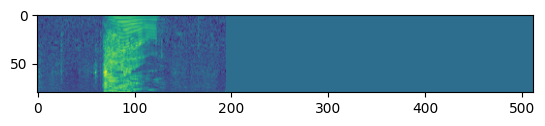

In [42]:
idx = 11
sample = asr_datasets["test"][idx]
S = torch.tensor(sample["in_spectrogram"]).to(device)

print(S.shape)

plt.figure()
plt.imshow(S.squeeze().detach().cpu())
plt.show()

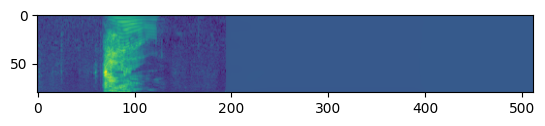

In [45]:
S_recon = reconstruct(S,epsilon=2.0)

plt.figure()
plt.imshow(S_recon.squeeze().detach().cpu())
plt.show()

In [47]:
def normalize_text(text):
    """Standardize text (lowercase, remove punctuation, trim spaces)"""
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

In [48]:
eval_dataset = asr_datasets["train"].shuffle() #.select(range(1000))

In [49]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import re

model.eval()
asr_model.eval()

metric = evaluate_lib.load("wer")
cer_metric = evaluate_lib.load("cer")

in_wers = []
in_cers = []
in_status = []
in_texts = []
new_wers = []
new_cers = []
new_status = []
new_texts = []
refs = []

with torch.no_grad():
    for j, sample in enumerate(eval_dataset):

        reference_text = sample['transcription']
    
        S = torch.tensor(sample["in_spectrogram"]).to(device)
        
        S_recon = reconstruct(S,epsilon=0.9).squeeze(1) # Get rid of the channel dim


        # S_new = sharpen(S_new, alpha=0.5)
        
        S_new_batch = torch.stack([S_recon,S_recon],dim=0)
        new_hypotheses = predict(S_new_batch.to(device))


        S_in_batch = torch.stack([S,S],dim=0)
        in_hypotheses = predict(S_in_batch.squeeze(1).to(device))


        reference_text = normalize_text(reference_text)
        in_pred = normalize_text(in_hypotheses[0].text)
        new_pred = normalize_text(new_hypotheses[0].text)
        
        wer_in = metric.compute(references=[reference_text], predictions=[in_pred])
        cer_in = cer_metric.compute(references=[reference_text], predictions=[in_pred])

        wer_new = metric.compute(references=[reference_text], predictions=[new_pred])
        cer_new = cer_metric.compute(references=[reference_text], predictions=[new_pred])

        d_wer = (wer_new - wer_in)/wer_in if wer_in > 0 else (wer_new - wer_in)/(wer_new + 1e-7)
        d_cer = (cer_new - cer_in)/cer_in if cer_in > 0 else (cer_new - cer_in)/(cer_new + 1e-7)

        in_wers.append(wer_in)
        in_cers.append(cer_in)
        in_texts.append(in_pred)
        new_wers.append(wer_new)
        new_cers.append(cer_new)
        new_texts.append(new_pred)
        refs.append(reference_text)

        in_stat = 0 if in_hypotheses[0].text == '' else 1
        new_stat = 0 if new_hypotheses[0].text == '' else 1

        in_status.append(in_stat)
        new_status.append(new_stat)

        print(f"Sample {j}/{len(eval_dataset)}")
        print(f"WER: {wer_in*100:.2f}%-->{wer_new*100:.2f}% ({d_wer:.4f})")
        print(f"CER: {cer_in*100:.2f}%-->{cer_new*100:.2f}% ({d_cer:.4f})")

        
        print(f"TRUE: {reference_text}")
        print(f"BASE: {[hyp.text for hyp in in_hypotheses]}")
        print(f"NEW: {[hyp.text for hyp in new_hypotheses]}")

        print("\n")





Sample 0/5016
WER: 100.00%-->100.00% (0.0000)
CER: 100.00%-->83.33% (-0.1667)
TRUE: sticks
BASE: ['', '']
NEW: ['two', 'two']


Sample 1/5016
WER: 77.78%-->88.89% (0.1429)
CER: 73.47%-->75.51% (0.0278)
TRUE: he dresses himself in an ancient black frock coat
BASE: ['he dreaded in town', 'he dreaded in town']
NEW: ['she dreaded in town', 'she dreaded in town']


Sample 2/5016
WER: 100.00%-->100.00% (0.0000)
CER: 120.00%-->100.00% (-0.1667)
TRUE: cycle
BASE: ['cycle cycle', 'cycle cycle']
NEW: ['sikh', 'sikh']


Sample 3/5016
WER: 100.00%-->100.00% (0.0000)
CER: 75.00%-->150.00% (1.0000)
TRUE: toot
BASE: ['hope', 'hope']
NEW: ['croaked', 'croaked']


Sample 4/5016
WER: 100.00%-->100.00% (0.0000)
CER: 80.00%-->80.00% (0.0000)
TRUE: cycle
BASE: ['psycho', 'psycho']
NEW: ['psycho', 'psycho']


Sample 5/5016
WER: 0.00%-->0.00% (0.0000)
CER: 0.00%-->0.00% (0.0000)
TRUE: he is definitely a notch above us
BASE: ['he is definitely a notch above us', 'he is definitely a notch above us']
NEW: ['he 

In [51]:
result = {
'in_wers': in_wers,
'in_cers': in_cers,
'in_status': in_status,
'in_texts': in_texts,
'new_wers': new_wers,
'new_cers': new_cers,
'new_status': new_status,
'new_texts': new_texts,
'refs': refs
}

import pandas as pd

resulf_df = pd.DataFrame.from_dict(result)

In [52]:
improvements = resulf_df[resulf_df['new_wers'] < resulf_df['in_wers']]

for i,row in improvements.iterrows():
    if row['new_texts'] != '':
        print(f"TRUE: {row['refs']}")
        print(f"BASE: {row['in_texts']}")
        print(f"PRED: {row['new_texts']}\n\n")

TRUE: three
BASE: three three
PRED: three


TRUE: jacket
BASE: jacket jack
PRED: jacket


TRUE: you can ride stagecoach
BASE: ukraine a stagecoach
PRED: you can ride a stagecoach


TRUE: ham
BASE: ham ham
PRED: ham


TRUE: park
BASE: pork pork pork
PRED: pork pork


TRUE: he will allow a rare lie
BASE: he will or low a wear lie or lie
PRED: she will allo a wear lie oh


TRUE: i scrubbed the floors thoroughly
BASE: i scrub the floor thoroughly scared
PRED: i scrub the floor thoroughly


TRUE: papa
BASE: proper proper
PRED: proper


TRUE: urgent
BASE: urgent urgent
PRED: urgent


TRUE: whoop
BASE: w what
PRED: woop whoop


TRUE: pat
BASE: pat pat
PRED: pat


TRUE: park
BASE: pollock pollock pollock
PRED: pollock


TRUE: witty
BASE: weddy we
PRED: weddy


TRUE: floor
BASE: 
PRED: floor


TRUE: the books are very expensive
BASE: the books are very expensive they are
PRED: the books are very expensive


TRUE: help celebrate your brothers success
BASE: help us out by your brothers sister hel

In [53]:
from scipy.stats import ttest_rel, wilcoxon


print(f"WER: {np.mean(in_wers)}-->{np.mean(new_wers)}")
print(f"CER: {np.mean(in_cers)}-->{np.mean(new_cers)}")

print(f"Median WER: {np.median(in_wers)}-->{np.median(new_wers)}")
print(f"Median CER: {np.median(in_cers)}-->{np.median(new_cers)}")

_, p_wer = ttest_rel(in_wers, new_wers)
_, p_cer = ttest_rel(in_cers, new_cers)

print(f"WER p-value: {p_wer}, CER p-value: {p_cer}")

WER: 0.7725688115490746-->0.7113265489162618
CER: 0.6311113470310387-->0.5591602213237999
Median WER: 1.0-->1.0
Median CER: 0.6666666666666666-->0.6
WER p-value: 9.930763824749498e-23, CER p-value: 8.303878986086542e-29


In [54]:
improved = sum(1 for i in range(len(in_wers)) if new_wers[i] < in_wers[i])
worsened = sum(1 for i in range(len(in_wers)) if new_wers[i] > in_wers[i])
same = sum(1 for i in range(len(in_wers)) if new_wers[i] == in_wers[i])

net_gain = improved - worsened
print(f"Improved: {improved}, Worsened: {worsened}, Net gain: {net_gain}")

improved_value = sum([in_wers[i] - new_wers[i] for i in range(len(in_wers)) if new_wers[i] < in_wers[i]])
worsened_value = sum([in_wers[i] - new_wers[i] for i in range(len(in_wers)) if new_wers[i] > in_wers[i]])

print(f"Improved value: {improved_value:.4f}, Worsened value: {worsened_value:.4f}, Net gain value: {improved_value + worsened_value:.4f}")

Improved: 648, Worsened: 377, Net gain: 271
Improved value: 593.3485, Worsened value: -286.1573, Net gain value: 307.1912


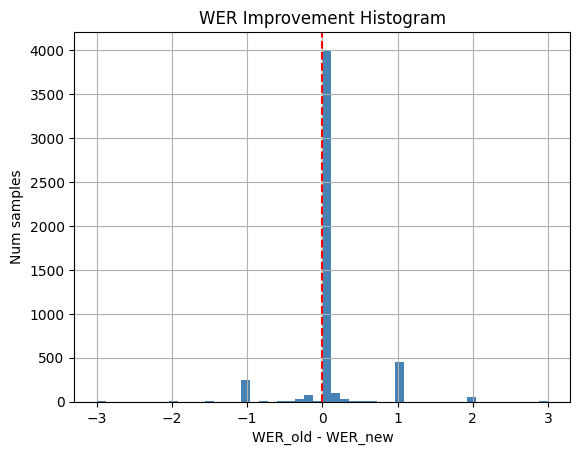

In [55]:
import matplotlib.pyplot as plt
deltas = [old - new for old, new in zip(in_wers, new_wers)]
plt.hist(deltas, bins=50, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("WER Improvement Histogram")
plt.xlabel("WER_old - WER_new")
plt.ylabel("Num samples")
plt.grid(True)
plt.show()

In [56]:
threshold = 0.99
wrong_base = {i for i, w in enumerate(in_wers) if w > threshold}
wrong_new = {i for i, w in enumerate(new_wers) if w > threshold}

fixed_by_model = wrong_base - wrong_new
broken_by_model = wrong_new - wrong_base
print(f"Fixed: {len(fixed_by_model)}, New errors: {len(broken_by_model)}")



Fixed: 354, New errors: 216


In [58]:
print("\nWER filtered (only samples with both new and old WER < 300%):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(in_wers):
    if in_wers[i] < 3.0 and new_wers[i] < 3.0:
        in_wers_filtered.append(in_wers[i])
        new_wers_filtered.append(new_wers[i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print("\nCER filtered (only samples with both new and old CER < 200%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if in_cers[i] < 2.0 and new_cers[i] < 2.0:
        in_cers_filtered.append(in_cers[i])
        new_cers_filtered.append(new_cers[i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with both new and old WER < 300%):
WER (4950 samples): 0.7412535674202341-->0.6925280746189837

CER filtered (only samples with both new and old CER < 200%):
CER (4887 samples): 0.5883616869913522-->0.5375349671466944


In [59]:
# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)

print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}")

Filtered WER p-value: 1.3355986469542407e-17, Filtered CER p-value: 8.303188056782022e-21


In [60]:
print("\nWER filtered (only samples with old WER > 50%):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(in_wers):
    if in_wers[i] > 0.5:
        in_wers_filtered.append(in_wers[i])
        new_wers_filtered.append(new_wers[i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print("\nCER filtered (only samples with old CER > 30%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if in_cers[i] > 0.3:
        in_cers_filtered.append(in_cers[i])
        new_cers_filtered.append(new_cers[i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with old WER > 50%):
WER (3417 samples): 1.1013552018819797-->0.9550873995123336

CER filtered (only samples with old CER > 30%):
CER (3399 samples): 0.910521737679027-->0.7540986443799848


In [61]:
# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)

print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}")

Filtered WER p-value: 2.0886245839010648e-74, Filtered CER p-value: 3.671785330644518e-74


In [62]:
cleaned_results = resulf_df[resulf_df['in_status'] == 1]
cleaned_results = cleaned_results[cleaned_results['new_status'] == 1]

len(cleaned_results)

print(f"WER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_wers'])}-->{np.mean(cleaned_results['new_wers'])}")
print(f"CER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_cers'])}-->{np.mean(cleaned_results['new_cers'])}")

_, p_wer = ttest_rel(cleaned_results['in_wers'], cleaned_results['new_wers'])
_, p_cer = ttest_rel(cleaned_results['in_cers'], cleaned_results['new_cers'])

print(f"Cleaned WER p-value: {p_wer} \nCleaned CER p-value: {p_cer}")

WER (4065 cleaned samples): 
0.7294384984975391-->0.6504280836015153
CER (4065 cleaned samples): 
0.5666143630386845-->0.47484959677017957
Cleaned WER p-value: 6.896854794073207e-29 
Cleaned CER p-value: 3.406701503536687e-36


In [68]:
whisper_model_id = "openai/whisper-medium"
whisper = WhisperForConditionalGeneration.from_pretrained(whisper_model_id).to(device)
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_id, language="en", task="transcribe")


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [79]:
def predict_whisper(S):
    
        S = S.to(device).unsqueeze(0)  # Add batch dim & move to GPU

        forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="en", task="transcribe")
    
        generated_ids = whisper.generate(
            S,
            do_sample=False,  # Disable randomness
            num_beams=3,      # Greedy decoding
            temperature=0.0,   # No sampling
            forced_decoder_ids=forced_decoder_ids,  # Force Italian language token
        )
        pred_text = whisper_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
        # Normalize both reference and predicted text
        pred_text = normalize_text(pred_text)

        return pred_text

In [84]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import torch.nn.functional as F

model.eval()
asr_model.eval()

metric = evaluate_lib.load("wer")
cer_metric = evaluate_lib.load("cer")

in_wers = []
in_cers = []
in_status = []
in_texts = []
new_wers = []
new_cers = []
new_status = []
new_texts = []
refs = []

with torch.no_grad():
    for j, sample in enumerate(eval_dataset):

        reference_text = sample['transcription']

        S = torch.tensor(sample["in_spectrogram"]).to(device)
        pred_text_in = predict_whisper(S)

        S_recon = reconstruct(S,epsilon=0.3).squeeze(1) # Get rid of the channel dim
        S_recon = S_recon.squeeze() 
        pred_text_new = predict_whisper(S_recon)
                
        wer_in = metric.compute(references=[reference_text], predictions=[pred_text_in])
        cer_in = cer_metric.compute(references=[reference_text], predictions=[pred_text_in])

        wer_new = metric.compute(references=[reference_text], predictions=[pred_text_new])
        cer_new = cer_metric.compute(references=[reference_text], predictions=[pred_text_new])

        d_wer = (wer_new - wer_in)/wer_in if wer_in > 0 else (wer_new - wer_in)/(wer_new + 1e-7)
        d_cer = (cer_new - cer_in)/cer_in if cer_in > 0 else (cer_new - cer_in)/(cer_new + 1e-7)

        in_wers.append(wer_in)
        in_cers.append(cer_in)
        in_texts.append(in_pred)
        new_wers.append(wer_new)
        new_cers.append(cer_new)
        new_texts.append(new_pred)
        refs.append(reference_text)

        in_stat = 0 if len(pred_text_in) > 2*len(reference_text) else 1
        new_stat = 0 if len(pred_text_in) > 2*len(reference_text) else 1

        in_status.append(in_stat)
        new_status.append(new_stat)
        
        print(f"Sample {j}/{len(eval_dataset)}")
        print(f"WER: {wer_in*100:.2f}%-->{wer_new*100:.2f}% ({d_wer:.4f})")
        print(f"CER: {cer_in*100:.2f}%-->{cer_new*100:.2f}% ({d_cer:.4f})")

        
        print(f"TRUE: {reference_text}")
        print(f"BASE: {pred_text_in}")
        print(f"NEW: {pred_text_new}")

        print("\n")





Sample 0/100
WER: 200.00%-->100.00% (-0.5000)
CER: 166.67%-->100.00% (-0.4000)
TRUE: top
BASE: im out
NEW: bye


Sample 1/100
WER: 100.00%-->100.00% (0.0000)
CER: 75.00%-->75.00% (0.0000)
TRUE: knew
BASE: bye
NEW: bye


Sample 2/100
WER: 300.00%-->400.00% (0.3333)
CER: 360.00%-->300.00% (-0.1667)
TRUE: group
BASE: thanks for watching
NEW: see you next time


Sample 3/100
WER: 300.00%-->300.00% (0.0000)
CER: 425.00%-->425.00% (0.0000)
TRUE: rake
BASE: thanks for watching
NEW: thanks for watching


Sample 4/100
WER: 600.00%-->700.00% (0.1667)
CER: 140.00%-->200.00% (0.4286)
TRUE: store
BASE: s t r o w e
NEW: s t r o i n g


Sample 5/100
WER: 200.00%-->1100.00% (4.5000)
CER: 220.00%-->960.00% (3.3636)
TRUE: droop
BASE: youre welcome
NEW: thanks for watching and ill see you in the next one


Sample 6/100
WER: 100.00%-->1100.00% (10.0000)
CER: 100.00%-->1633.33% (15.3333)
TRUE: tip
BASE: beep
NEW: thanks for watching and ill see you in the next one


Sample 7/100
WER: 100.00%-->300.00% (2.0


KeyboardInterrupt



In [ ]:
whisper_result = {
'in_wers': in_wers,
'in_cers': in_cers,
'in_status': in_status,
'in_texts': in_texts,
'new_wers': new_wers,
'new_cers': new_cers,
'new_status': new_status,
'new_texts': new_texts,
'refs': refs
}


whisper_resulf_df = pd.DataFrame.from_dict(whisper_result)